# 05_event_database.ipynb
### Create a database extreme events


In [14]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import regionprops 
from dask_image.ndmeasure import label as label_dask
from skimage.measure import label as label_np
from datetime import date


#### Import Ocetrac labels and SST data


In [15]:
file_path_list = ('/burg/abernathey/users/hillary/oisst_v21/ocetrac_notrend.nc',
        '/burg/abernathey/users/hillary/oisst_v21/positive_extremes_OISSTv21.nc')

ds = xr.open_mfdataset(file_path_list)
ssta = ds.mhw_ssta_notrend
labels = ds.ocetrac_labels

num_events = labels.attrs['final objects tracked']
print(f"There are {num_events} total events tracked.")

There are 770 total events tracked.



TODO:

1. Look at distributions of events with different ENSO indices
   - accumulated area over the entire event
   - duration
   - number of events with footprints within the tropics +/- 10º Indian and Pacific only



2. Cluster trajectoreis of objects 
   - Find trajectories based on the centroid with the largest object


#### Event Database

- ID
- date
    - initial time (mm-yy)
    - final time (mm-yy)
- duration
- coordinates (lat,lon)
- centroid(s) (lat, lon)
- *number of centroids*
- *maximum distance between centroids*
- mean intensity
- maximum intensity
- minimum intensity
- cumulative intensity
- area
- *Nino index*



In [27]:
def _get_labels(binary_images):
    '''function used to label binary images at each time step using skimage.measure.label'''
    blobs_labels = label_np(binary_images, background=0)
    return blobs_labels
    
def _get_centroids(sub_labels):
    '''This function uses skimage.measure.regionprops to find the centroids of objects assigned 
    to each unique label'''
    props = regionprops(sub_labels.astype('int'))
    centroids = [(float(sub_labels.lat[round(p.centroid[0])].values), 
                  float(sub_labels.lon[round(p.centroid[1])].values)) for p in props]
    return centroids

def _get_intensity_area(event, ssta, mhw):
    '''Calculates event intensities and area at each time interval using anomaly data and coordinates 
    cooresponding to the event.'''
    
    event_ssta = ssta.where(event>0, drop=True)        
    mhw['intensity_mean'].append(event_ssta.mean(('lat','lon')).values)
    mhw['intensity_max'].append(event_ssta.max(('lat','lon')).values) 
    mhw['intensity_min'].append(event_ssta.min(('lat','lon')).values)
    mhw['intensity_cumulative'].append(np.nansum(event_ssta))
    coords = event.stack(z=('lat','lon'))
    coord_pairs = [(coords.isel(time=t[0]).dropna(dim='z', how='any').z.lat.values, 
                      coords.isel(time=t[0]).dropna(dim='z', how='any').z.lon.values) for t in enumerate(event.time)]

    mhw['coords'].append(coord_pairs)

    # Calculate weighted cell area assuming 0.25º resolution data and 111 km per degree of latitude
    y, x = zip(*coord_pairs)
    dlon = [np.cos(y[c]*np.pi/180)*(111*.25) for c in np.arange(0, len(coord_pairs))]
    dlat = (111*.25) * np.ones(len(dlon))
    cell_area = [np.sum(dlon[c]*dlat[c]) for c in np.arange(0, len(coord_pairs))]
    mhw['area'].append(cell_area)

    return mhw
    
def create_database(event, ssta):
    '''
    Creates a Pandas DataFrame of event attributes.
    
    Parameters
    ----------
      event : xarray.DataArray   
              Image set containing only objects corresponding to the event of interest. 
              Dimensions should be ('time', 'lat', 'lon')
              
      ssta  : xarray.DataArray
              Temperature vector [1D numpy array of length T]
    
    Returns
    -------
    
    mhw : pandas.DataFrame
          Marine heat wave event attributes. The keys listed below are 
          are contained within the database.
 
        'id'                     Unique label given to the MHW [int]
        'date'                   Dates corresponding to the event [datetime format]
        'coords'                 Latitude and longitude of all points contained in the event [tuple(lat,lon)]
        'centroid'               Center of each object contained in the event [tuple(lat,lon)]
        'duration'               Duration of event [months]
        'intensity_max'          Maximum intensity at each time interval [degC]
        'intensity_mean'         Mean intensity at each time interval [degC]
        'intensity_min'          Minimum intensity at each time interval [degC]
        'intensity_cumulative'   Cumulated intensity over the entire event [degC months]
        'area'                   Area of the event at each time interval [km2]
        
    '''
    
    # Initialize dictionary 
    mhw = {}
    mhw['id'] = [] # event label
    mhw['date'] = [] # datetime format
    mhw['coords'] = [] # (lat, lon)
    mhw['centroid'] = []  # (lat, lon)
    mhw['duration'] = [] # [months]
    mhw['intensity_max'] = [] # [deg C]
    mhw['intensity_mean'] = [] # [deg C]
    mhw['intensity_min'] = [] # [deg C]
    mhw['intensity_cumulative'] = [] # [deg C]
    mhw['area'] = [] # [km2]

    # TO ADD:
    # mhw['rate_onset'] = [] # [deg C / month]
    # mhw['rate_decline'] = [] # [deg C / month]

    mhw['id'].append(int(np.nanmedian(event.values)))
    mhw['date'].append(event.time.values.astype('datetime64[M]'))
    mhw['duration'].append(event.time.shape[0])

    # Turn images into binary
    binary_event = event.where(event>=0, other=0)
    binary_event = binary_event.where(binary_event==0, other=1)
      
    sub_labels = xr.apply_ufunc(_get_labels, binary_event,
                                input_core_dims=[['lat', 'lon']],
                                output_core_dims=[['lat', 'lon']],
                                output_dtypes=[binary_event.dtype],
                                vectorize=True,
                                dask='parallelized')
    
    # Turn background to NaNs
    sub_labels = xr.DataArray(sub_labels, dims=binary_event.dims, coords=binary_event.coords)
    sub_labels = sub_labels.where(sub_labels>0, drop=False, other=np.nan) 

    # The labels are repeated each time step, therefore we relabel them to be consecutive
    for p in range(1, sub_labels.shape[0]):
        sub_labels[p,:,:] = sub_labels[p,:,:].values + sub_labels[p-1,:,:].max().values

    centroid = []
    for s in np.arange(0, sub_labels.shape[0]):
        centroid.append(_get_centroids(sub_labels.isel(time=s)))
    mhw['centroid'].append(centroid)
    
    mhw = _get_intensity_area(event, ssta, mhw)
    
    mhw = pd.DataFrame(dict([(name, pd.Series(data)) for name,data in mhw.items()]))

    return mhw


In [17]:
# Loop through labels to fill database
for i in np.arange(1,5):#num_events+1):
    print(i)
    event = labels.where(labels==i, drop=True)
    mhw = create_database(event, ssta)
    
print(f'The keys in this database are {list(mhw)}.')

1
2
3
4


/burg/home/hs3277/.conda/envs/marine-heatwaves/lib/python3.9/site-packages/xarray/core/indexing.py:1232: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/burg/home/hs3277/.conda/envs/marine-heatwaves/lib/python3.9/site-packages/xarray/core/indexing.py:1232: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
  

The keys in this database are ['id', 'date', 'coords', 'centroid', 'duration', 'intensity_max', 'intensity_mean', 'intensity_min', 'intensity_cumulative', 'area'].


In [18]:
# Create a Pandas DataFrame with event information
df = pd.DataFrame(dict([(name, pd.Series(data)) for name,data in mhw.items()]))
df

,id,date,coords,centroid,duration,intensity_max,intensity_mean,intensity_min,intensity_cumulative,area
0,4,"[1981-09, 1981-10, 1981-11, 1981-12, 1982-01, ...","[([5.625, 5.625, 5.625, 5.625, 5.625, 5.625, 5...","[[(20.125, 286.625)], [(16.625, 288.375), (54....",8,"[1.2878051775076536, 1.6641764306870521, 3.503...","[0.687826202241888, 0.7339108416029536, 0.8247...","[0.33745582149181885, 0.22873864245268116, 0.2...",50976.814128,"[4840552.2594525125, 4452807.745606111, 833196..."


### Code below is helpful for debugging

Let's walk through an example for a single event.

In [28]:
i = 4 #651

In [29]:
event = labels.where(labels==i, drop=True)
print(f'The event is labeled {i}')
print(f'This event lasted {event.time.shape[0]} months.')
print('The dates for this event were', event.time[0].values.astype('datetime64[M]'),
      '–', event.time[-1].values.astype('datetime64[M]'))


The event is labeled 4
This event lasted 8 months.
The dates for this event were 1981-09 – 1982-04


/burg/home/hs3277/.conda/envs/marine-heatwaves/lib/python3.9/site-packages/xarray/core/indexing.py:1232: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


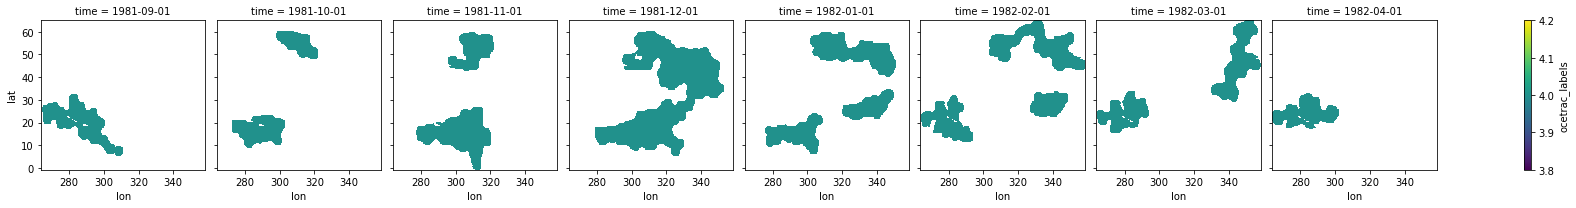

In [30]:
event.plot(col='time', col_wrap=event.shape[0], robust=True);


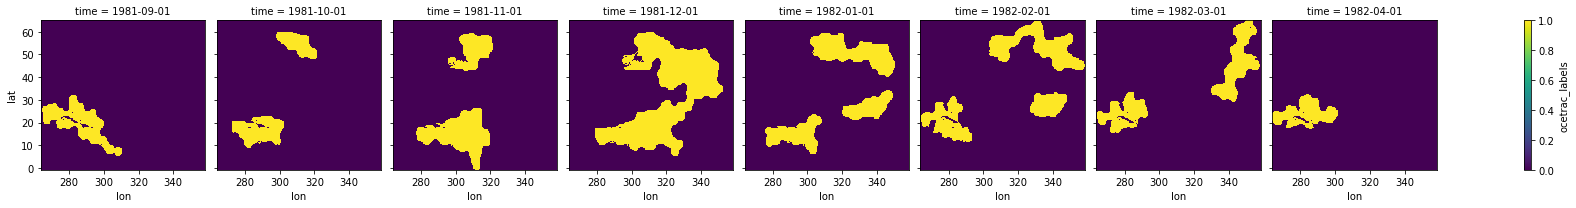

In [9]:
# Turn this event into a binary image set
binary_event = event.where(event>=0, other=0)
binary_event = binary_event.where(binary_event==0, other=1)
binary_event.plot(col='time', col_wrap=event.shape[0], robust=True);


In [31]:
%%time
mhw = create_database(event, ssta)

/burg/home/hs3277/.conda/envs/marine-heatwaves/lib/python3.9/site-packages/xarray/core/indexing.py:1232: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


CPU times: user 1min 47s, sys: 55.6 s, total: 2min 43s
Wall time: 1min 50s


In [32]:
mhw

,id,date,coords,centroid,duration,intensity_max,intensity_mean,intensity_min,intensity_cumulative,area
0,4,"[1981-09, 1981-10, 1981-11, 1981-12, 1982-01, ...","[([5.625, 5.625, 5.625, 5.625, 5.625, 5.625, 5...","[[(20.125, 286.625)], [(16.625, 288.375), (54....",8,"[1.2878051775076536, 1.6641764306870521, 3.503...","[0.687826202241888, 0.7339108416029536, 0.8247...","[0.33745582149181885, 0.22873864245268116, 0.2...",50976.814128,"[4840552.2594525125, 4452807.745606111, 833196..."


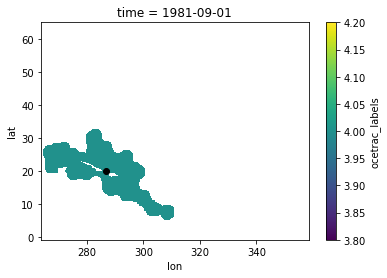

mean intensity (ºC) 0.69
max intensity (ºC) 1.29
min intensity (ºC) 0.34
area (km2) 4840552.26


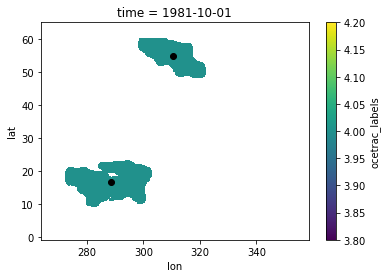

mean intensity (ºC) 0.73
max intensity (ºC) 1.66
min intensity (ºC) 0.23
area (km2) 4452807.75


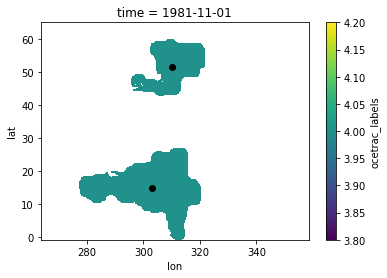

mean intensity (ºC) 0.82
max intensity (ºC) 3.5
min intensity (ºC) 0.25
area (km2) 8331967.72


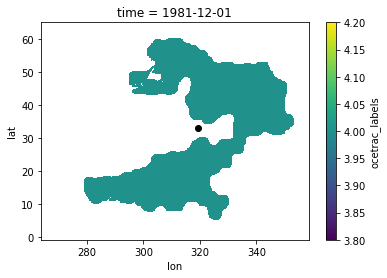

mean intensity (ºC) 1.02
max intensity (ºC) 4.08
min intensity (ºC) 0.26
area (km2) 15953246.35


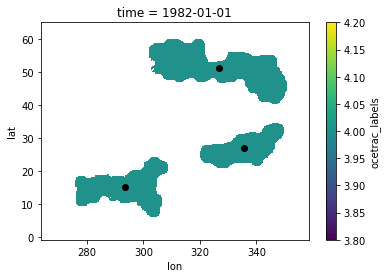

mean intensity (ºC) 0.87
max intensity (ºC) 2.54
min intensity (ºC) 0.25
area (km2) 9355278.43


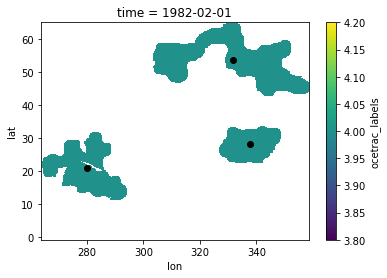

mean intensity (ºC) 0.78
max intensity (ºC) 3.58
min intensity (ºC) 0.07
area (km2) 8987995.54


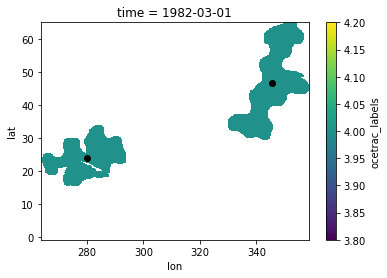

mean intensity (ºC) 0.83
max intensity (ºC) 2.84
min intensity (ºC) 0.17
area (km2) 6401833.79


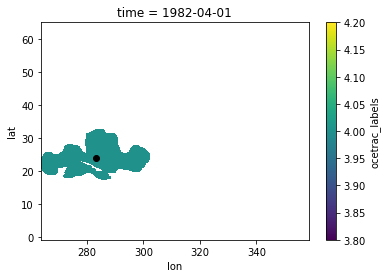

mean intensity (ºC) 0.97
max intensity (ºC) 2.12
min intensity (ºC) 0.2
area (km2) 3440826.05


In [33]:
for c in np.arange(0,mhw['duration'][0]):
    plt.figure()
    y, x = zip(*mhw['centroid'][0][c])
    event[c,:,:].plot()
    plt.scatter(x, y, c='k')
    plt.show()
    print('mean intensity (ºC)', round(mhw['intensity_mean'][0][c],2))
    print('max intensity (ºC)', round(mhw['intensity_max'][0][c],2))
    print('min intensity (ºC)', round(mhw['intensity_min'][0][c],2))
    print('area (km2)', round(mhw['area'][0][c],2))